In [1]:
import pickle
import matplotlib.pyplot as plt
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import pytorch_lightning as L
from pytorch_lightning import loggers as pl_loggers
import torch
torch.manual_seed(40)
import pdb
import numpy as np
from torchmetrics.text import CharErrorRate, WordErrorRate
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import glob
import os.path
import hashlib
from torchvision.models import resnet18

/home/stanley/anaconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2023-12-14 16:38:25.871079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 16:38:25.891092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 16:38:25.891112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already

In [2]:
#all_chars = " ,-.ABCDEFGHIJKLMNOPQRSTUVWXabcdefghijklmnopqrstuvwxyz¶"
all_chars = " -.ABCDEFGHIJKLMNOPQRSTUVWXabcdefghijklmnopqrstuvwxyz¶"
print(len(all_chars))
char_to_num = {}
num_to_char = {}
for i in range(len(all_chars)):
    num_to_char[i+1] = all_chars[i]
    char_to_num[all_chars[i]] = i+1

54


In [3]:
class LineImageDataset(Dataset):
    def classify(self, line_im_filename):
        str_hash = hashlib.md5(line_im_filename.encode()).hexdigest()
        hash_num = int(str_hash[:8], 16) % 100 #"random" num between 0 and 99
        if hash_num < 90: return "train"
        else: return "val"
    
    def __init__(self, dirname, char_to_num, num_to_char, data_type, transform=None):
        self.transform = transform       
        self.char_to_num = char_to_num
        self.num_to_char = num_to_char
        self.data_type = data_type
        self.line_images = []
        self.line_image_filenames = []
        self.labels = []
        self.num_labels = []
        
        #Iterate over all lines of all XML files
        ns = {'ns': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
        ET.register_namespace('', ns['ns'])

        #print(dirname)
        #print(glob.glob("./data/*.xml"))
        for filename in sorted(glob.glob(dirname + "/*.xml")):
            #print(filename)
            tree = ET.parse(filename)
            root = tree.getroot()

            image_filename = root.find('ns:Page', ns).get('imageFilename')

            #First iteration: calculate average line spacing
            for text_region in root.findall('.//ns:TextRegion', ns):
                for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):                    
                    line_im_filename = dirname + "/line_{}_{}".format(lineno, image_filename)
                    line_im_filename, _ = os.path.splitext(line_im_filename)
                    line_im_filename += ".png"
                    if data_type != "all" and self.classify(line_im_filename) != data_type:
                        continue
                        
                    self.line_image_filenames.append(line_im_filename)
                    #self.line_images.append(read_image(line_im_filename, ImageReadMode.GRAY))   
                    self.line_images.append(torch.tensor(np.load(line_im_filename.replace(".png", ".npy")), dtype=torch.float32).unsqueeze(0))
                    
                    text = text_line.find('.//ns:TextEquiv', ns).find('.//ns:Unicode', ns).text
                    text = text.strip()
                    text = text.replace(",", ".")
                    
                    self.labels.append(text)
                    self.num_labels.append(torch.tensor([self.char_to_num[c] for c in text]))

                                        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):                
        image = self.line_images[idx]
        
        if self.transform is not None:
            image = self.transform(image)
       
        return {"image": image, "target": self.num_labels[idx], "text": self.labels[idx]}


In [4]:
train_transform = transforms.Compose(
    [
       transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
       transforms.RandomAffine(0.7, translate=(0.01, 0.02), scale=(0.98, 1.02)),
       transforms.RandomChoice([
            transforms.RandomAdjustSharpness(2, p=0.5),
            transforms.GaussianBlur(21, (1,6))
        ]),      
        transforms.Normalize(0.15, 0.38)
    ])

val_transform = transforms.Compose(
    [  
        transforms.Normalize(0.15, 0.38)
    ])

#train_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="train", transform=train_transform)
#val_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="val", transform=val_transform)

In [5]:
dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="all", transform=val_transform)
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_indices, val_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, val_size])

train_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="all", transform=train_transform)
val_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="all", transform=val_transform)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

tensor(0.0781) tensor(0.9854)


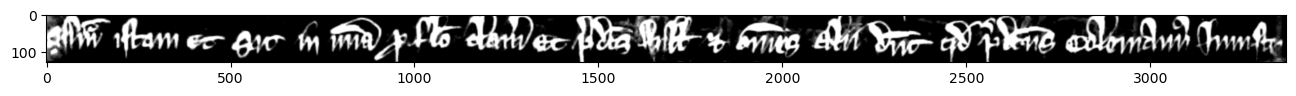

In [6]:
#plt.imshow(torch.tensor(np.load("data/line_0_0001_JUST1-734m5d.npy")))
idx = 40
print(val_dataset[idx]["image"][0].mean(), val_dataset[idx]["image"][0].std())
plt.figure(figsize=(16,6))
plt.imshow(train_dataset[20]["image"][0], cmap="gray")

In [7]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, (4,16), padding=(1,7)),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
            nn.Conv2d(32, 32, (4,16), padding=(1,7)),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
            nn.Conv2d(32, 64, (3,8), padding=(1,3)),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
            nn.Conv2d(64, 64, (3,8), padding=(1,3)),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
                            
        self.lstms = nn.ModuleList([
            nn.LSTM(960, 256, bidirectional=True, batch_first=True),
            nn.Dropout1d(0.3),
            nn.LSTM(512, 256, bidirectional=True, batch_first=True),
            nn.Dropout1d(0.3),
            nn.LSTM(512, 256, bidirectional=True, batch_first=True),
            nn.Dropout1d(0.3),
        ])
        self.lin = nn.Linear(512, len(all_chars))

    def forward(self, x):
        x = self.features(x)
        x = x.contiguous().view(-1, x.shape[1] * x.shape[2], x.shape[3]).transpose(1,2)
        
        for layer in self.lstms:
            if isinstance(layer, nn.LSTM):
                x, _ = layer(x)
            elif isinstance(layer, nn.Dropout1d):
                #Current dimensions are (N,L,C).  We want (N,C,L) so dropout can be per channel. Then we transpose back.
                x = x.transpose(1,2)
                assert(x.shape[1] == 512) #should be double LSTM hidden size
                x = layer(x)
                x = x.transpose(1,2)
            else:
                assert(False)
        x = self.lin(x)
        x = nn.functional.log_softmax(x, dim=2)
        return x.transpose(1,2)

net = MyNN()
#torch.save(net, "my_model.pt")

In [8]:
# net = torch.load("kraken_model.pt")
# net.train()

In [9]:
# class MyNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, (4,16), padding=(1,7)),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),            
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Conv2d(32, 32, (4,16), padding=(1,7)),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Conv2d(32, 64, (3,8), padding=(1,3)),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#             nn.Conv2d(64, 64, (3,8), padding=(1,3)),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#         )

#         # self.features = nn.Sequential(
#         #     nn.Conv2d(1, 32, 5, padding=2),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(32),            
#         #     nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#         #     nn.Conv2d(32, 32, 5, padding=1),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(32),
#         #     nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#         #     nn.Conv2d(32, 64, 4, padding=1),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(64),
#         #     nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#         #     nn.Conv2d(64, 64, 3, padding=1),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(64),
#         # )
        
#         #self.pos_encoder = nn.Linear(960, 62)
#         #encoder_layers = nn.TransformerEncoderLayer(62, nhead=2, dim_feedforward=1024, batch_first=True)
#         #self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=3)
                
#         self.lstms = nn.ModuleList([
#             nn.LSTM(960, 256, bidirectional=True, batch_first=True),
#             #nn.BatchNorm1d(256),
#             nn.Dropout1d(0.3),
#             nn.LSTM(512, 256, bidirectional=True, batch_first=True),
#             nn.Dropout1d(0.3),
#             #nn.BatchNorm1d(256),
#             nn.LSTM(512, 256, bidirectional=True, batch_first=True),
#             nn.Dropout1d(0.3),
#         ])
#         self.lin = nn.Linear(512, len(all_chars))

#     def forward(self, x):
#         x = self.features(x)
#         x = x.contiguous().view(-1, x.shape[1] * x.shape[2], x.shape[3]).transpose(1,2)
#         #print(x.shape)
#         for layer in self.lstms:
#             if isinstance(layer, nn.LSTM):
#                 x, _ = layer(x)
#             elif isinstance(layer, nn.Dropout1d):
#                 #Current dimensions are (N,L,C).  We want (N,C,L) so dropout can be per channel. Then we transpose back.
#                 x = x.transpose(1,2)
#                 assert(x.shape[1] == 512) #should be double LSTM hidden size
#                 x = layer(x)
#                 x = x.transpose(1,2)
#             else:
#                 assert(False)
        
#         #x = self.pos_encoder(x)
#         #x = self.transformer_encoder(x)
#         x = self.lin(x)
#         x = nn.functional.log_softmax(x, dim=2)
#         return x.transpose(1,2)

# net = MyNN()

In [10]:
#device = torch.device("cuda")

class LatinTranscriber(L.LightningModule):
    def __init__(self, net, codec_l2c):
        super().__init__()
        self.codec_l2c = codec_l2c
        self.cer_calc = CharErrorRate()
        self.wer_calc = WordErrorRate()
        self.train_cer_calc = CharErrorRate()
        self.train_wer_calc = WordErrorRate()
        self.net = net
                
    def get_loss(self, batch, batch_idx):
        #input, _, target = batch
        
        target = batch["target"]
        target_length = batch["target"].shape[1]
       
        #self.net = self.net.to(device)
        input = batch["image"]#.to(device)
        
        #output, _ = self.net(input)
        #print("output dim", output.shape)
        output = self.net(input)
        #print("Output shape", output.shape)
        # height should be 1 by now
        #if output.size(2) != 1:
        #    raise ValueError('Expected dimension 3 to be 1, actual {}'.format(output.size(2)))
        #output = output.squeeze(2)
        #print("output", output)
        output_length = output.shape[-1]
        
        loss_func = nn.CTCLoss(reduction='sum', zero_infinity=True)
        loss = loss_func(output.permute(2,0,1), target, (output_length,), (target_length,))
        return loss, output
    
    def on_train_epoch_start(self):
        self.train_cer_calc.reset()
        self.train_wer_calc.reset()
        
        
    def _get_current_lr(self):
        for param_group in self.trainer.optimizers[0].param_groups:
            return param_group['lr']
        
    def on_train_epoch_end(self):
        char_accuracy = 1 - self.train_cer_calc.compute()
        word_accuracy = 1 - self.train_wer_calc.compute()
        lr = self._get_current_lr()
        
        self.log("train_char_acc", char_accuracy)
        self.log("train_word_acc", word_accuracy)
        self.log('lr-Adam', lr)

    def training_step(self, batch, batch_idx):
        assert self.net.training
        loss, output = self.get_loss(batch, batch_idx)
        prediction, truth = self.get_prediction_and_truth(output, batch["target"])
        self.train_cer_calc.update(truth, prediction)
        self.train_wer_calc.update(truth, prediction)
        self.log("train_loss", loss)
        return loss
    
    def get_prediction_and_truth(self, output, target):
        target = torch.squeeze(target).cpu().numpy()
        #truth = ''.join([self.codec_l2c[(target[i].item(),)] for i in range(len(target))])        
        truth = ''.join([self.codec_l2c[target[i].item()] for i in range(len(target))])  
        labels = torch.argmax(torch.squeeze(output), axis=0).cpu().numpy()
        prediction = ""
        for i in range(len(labels)):
            label = labels[i]
            if label != 0 and (i==0 or label != labels[i-1]):
                #prediction += self.codec_l2c[(label,)]
                prediction += self.codec_l2c[label]
                
        return prediction, truth
    
    def validation_step(self, batch, batch_idx):
        assert not self.net.training
        assert batch["target"].shape[0] == 1
        loss, output = self.get_loss(batch, batch_idx)
        prediction, truth = self.get_prediction_and_truth(output, batch["target"])
        self.cer_calc.update(truth, prediction)
        self.wer_calc.update(truth, prediction)

        # Get tensorboard logger
        if batch_idx < 16:
            tb_logger = None
            for logger in self.trainer.loggers:
                if isinstance(logger, pl_loggers.TensorBoardLogger):
                    tb_logger = logger.experiment
                    break

            tb_logger.add_image(f'Validation #{batch_idx}, target: {truth}', batch['image'][0], self.global_step, dataformats="CHW")
            tb_logger.add_text(f'Validation #{batch_idx}, target: {truth}', prediction, self.global_step)

        return loss
    
    def on_validation_epoch_start(self):
        self.cer_calc.reset()
        self.wer_calc.reset()
        
    def on_validation_epoch_end(self):
        char_accuracy = 1 - self.cer_calc.compute()
        word_accuracy = 1 - self.wer_calc.compute()
        print("Epoch, char acc, word acc:", self.current_epoch, round(char_accuracy.item(), 4), round(word_accuracy.item(), 4))
        self.log("val_char_acc", char_accuracy)
        self.log("val_word_acc", word_accuracy)


    def configure_optimizers(self):        
#         optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-1)
#         '''self.scheduler = optim.lr_scheduler.OneCycleLR(
#                                         optimizer, max_lr=3e-3,
#                                         steps_per_epoch=492,
#                                         epochs=100)
#         sched = {
#             'scheduler': self.scheduler,
#             'interval': 'step'
#         }
#         return {"optimizer": optimizer, "lr_scheduler": sched}'''
                      

        # optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-2)
        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": {
        #         "name": "lr-scheduler",
        #         "scheduler": optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.34, min_lr=1e-4, patience=15),
        #         "monitor": "val_word_acc",
        #         "frequency": 1
        #     },
        # }
        
        optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=0)
        return optimizer

transcriber = LatinTranscriber(net, num_to_char)

tensor(-2.7178) tensor(5.0789)


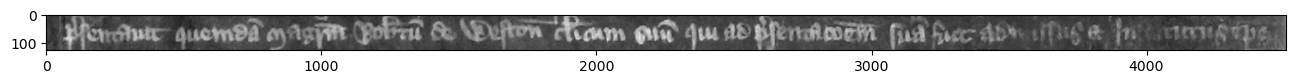

In [11]:
plt.figure(figsize=(16,6))
idx = 10
print(torch.min(val_dataset[idx]["image"]), torch.max(val_dataset[idx]["image"]))
plt.imshow(val_dataset[idx]["image"][0], cmap="gray")

In [12]:
train_loader = utils.data.DataLoader(train_dataset, num_workers=4)
valid_loader = utils.data.DataLoader(val_dataset, num_workers=4)

In [13]:
trainer = L.Trainer(accumulate_grad_batches=1, max_epochs=250, enable_progress_bar=False)
trainer.fit(transcriber, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params
-------------------------------------------------
0 | cer_calc       | CharErrorRate | 0     
1 | wer_calc       | WordErrorRate | 0     
2 | train_cer_calc | CharErrorRate | 0     
3 | train_wer_calc | WordErrorRate | 0     
4 | net            | MyNN          | 5.9 M 
-------------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total par

Epoch, char acc, word acc: 0 -57.0 -18.0
Epoch, char acc, word acc: 0 -inf -inf
Epoch, char acc, word acc: 1 -inf -inf
Epoch, char acc, word acc: 2 -inf -inf
Epoch, char acc, word acc: 3 -inf -inf
Epoch, char acc, word acc: 4 -inf -inf
Epoch, char acc, word acc: 5 -inf -inf
Epoch, char acc, word acc: 6 -inf -inf
Epoch, char acc, word acc: 7 -inf -inf
Epoch, char acc, word acc: 8 -inf -inf
Epoch, char acc, word acc: 9 -inf -inf
Epoch, char acc, word acc: 10 -inf -inf
Epoch, char acc, word acc: 11 -inf -inf
Epoch, char acc, word acc: 12 -inf -inf
Epoch, char acc, word acc: 13 -inf -inf
Epoch, char acc, word acc: 14 -inf -inf
Epoch, char acc, word acc: 15 -inf -inf
Epoch, char acc, word acc: 16 -inf -inf
Epoch, char acc, word acc: 17 -5.2266 -935.0
Epoch, char acc, word acc: 18 -3.4845 -2.8519
Epoch, char acc, word acc: 19 -3.2804 -2.12
Epoch, char acc, word acc: 20 -2.5669 -1.0571
Epoch, char acc, word acc: 21 -1.4858 -0.3644
Epoch, char acc, word acc: 22 -1.0551 -0.1615
Epoch, char acc,

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch, char acc, word acc: 249 0.869 0.6206


In [17]:
#torch.save(net.state_dict(), "my_custom_best.pt") %94% char, 82% word
#torch.save(net.state_dict(), "my_aguillar_repro.pt") #91% char, 69% word
#torch.save(net.state_dict(), "my_all_custom_best.pt") #88% char, 66% word
#torch.save(net, "kraken_mine_hybrid.pt") #Replace j with i, remove punctuation except period, kraken neural net, augmentation: 87% char, 64% word
#torch.save(net, "kraken_mine_repro.pt") #Ibid, but own net: 85% char, 62% word (2% lower??)
#torch.save(net, "kraken_mine_hybrid_lowercase.pt") #Replace j with i, remove puncutation, lowercase: 89% char, 68% word (at highest)

#torch.save(net, "fiducial.pt") #Fiducial model (Aguillar architecture): 87% char, 62% word?  Maximum was 64%.  Only 60% with batch normalization

In [15]:
# for i in range(len(val_dataset)):
#     plt.figure(figsize=(10,6))
#     plt.imshow(val_dataset[i]["image"][0])

In [16]:
#print(self.get_loss(batch)